In [10]:
import pandas as pd
import os, sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import NnClass

In [11]:
# use this one if on laptop
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'mini_train_data.csv'))

# use this one if on pc
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

In [12]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0  # Normalize only once

labels = pd.get_dummies(labels, columns=['Label'], dtype=int).values   #onehot encoding
print("features shape:", features.shape)
print("labels shape:", labels.shape)

features shape: (653, 70113)
labels shape: (653, 10)


## Original Train-Validation Split (Commented Out)

The simple random split method - commented out in favor of advanced author grouping.

In [13]:
# # Original simple train-validation split (commented out)
# trset,vset=NnClass.tv_split(df,0.8,semilla=99)

# trFeatures = trset.drop(columns=['label']).values.astype(np.float32)
# trFeatures /= 255.0  # This was redundant - features already normalized above
# trLabels=trset["label"].values.astype(np.int64)
# trLabels = pd.get_dummies(trLabels, columns=['Label'], dtype=int).values   #onehot encoding

# vFeatures = vset.drop(columns=['label']).values.astype(np.float32)
# vFeatures /= 255.0  # This was redundant - features already normalized above
# vLabels=vset["label"].values.astype(np.int64)
# vLabels = pd.get_dummies(vLabels, columns=['Label'], dtype=int).values   #onehot encoding

# fcnn=NnClass.Nn(trainX=trFeatures, trainY=trLabels,m=[512, 128, 32],seed=99)

### El split based on grouping

In [ ]:
# Advanced Train-Validation Split with Author Grouping
import importlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import split

# Load the spectrogram metadata to get author information
spects_df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_spects.csv'))

print(f"Loaded spectrogram metadata: {len(spects_df)} entries")
print(f"CSV training data: {len(df)} entries")

# Create a mapping from CSV to spectrogram metadata for author information
# The CSV rows correspond to spectrograms in order, so we can map by index
if len(df) <= len(spects_df):
    # Map the first len(df) spectrogram entries to CSV entries
    metadata_subset = spects_df.iloc[:len(df)].copy()
    metadata_subset['sample_idx'] = range(len(df))
    metadata_subset['usable_segments'] = 1  # Each row represents 1 segment
    
    print(f"Created metadata mapping for {len(metadata_subset)} sWamples")
    print(f"Unique authors: {metadata_subset['author'].nunique()}")
    print(f"Unique classes: {metadata_subset['class_id'].nunique()}")
    
    # Find the best 80-20 split using author grouping
    print("Finding best 80-20 split with author grouping...")
    dev_df, test_df, best_split_score, best_seed = split.search_best_group_seed(
        df=metadata_subset,
        test_size=0.2,
        max_attempts=2000,
        min_test_segments=2
    )
    
    # Extract indices for the split
    train_indices = dev_df['sample_idx'].values
    val_indices = test_df['sample_idx'].values
    
    print(f"Best 80-20 split found with score: {best_split_score:.3f}")
    print(f"Train samples: {len(train_indices)}, Validation samples: {len(val_indices)}")
    
    # Create training and validation sets using the grouped split
    trFeatures = features[train_indices]  # Already normalized
    trLabels = labels[train_indices]      # Already one-hot encoded
    
    vFeatures = features[val_indices]     # Already normalized
    vLabels = labels[val_indices]         # Already one-hot encoded
    
    print(f"Training features shape: {trFeatures.shape}")
    print(f"Training labels shape: {trLabels.shape}")
    print(f"Validation features shape: {vFeatures.shape}")
    print(f"Validation labels shape: {vLabels.shape}")
    
    # Initialize FCNN with grouped split data
    fcnn = NnClass.Nn(trainX=trFeatures, trainY=trLabels, m=[512, 128, 32], seed=99)
    
else:
    print(f"Warning: CSV has more entries ({len(df)}) than spectrogram metadata ({len(spects_df)})")
    print("Falling back to simple random split...")
    
    # Fallback to simple split if metadata mapping fails
    trset, vset = NnClass.tv_split(df, 0.8, semilla=99)
    
    trFeatures = trset.drop(columns=['label']).values.astype(np.float32)
    trFeatures /= 255.0  # Normalize since we're working with raw CSV
    trLabels = trset["label"].values.astype(np.int64)
    trLabels = pd.get_dummies(trLabels, columns=['Label'], dtype=int).values
    
    vFeatures = vset.drop(columns=['label']).values.astype(np.float32)
    vFeatures /= 255.0  # Normalize since we're working with raw CSV
    vLabels = vset["label"].values.astype(np.int64)
    vLabels = pd.get_dummies(vLabels, columns=['Label'], dtype=int).values
    
    fcnn = NnClass.Nn(trainX=trFeatures, trainY=trLabels, m=[512, 128, 32], seed=99)

Loaded spectrogram metadata: 2985 entries
CSV training data: 653 entries
Created metadata mapping for 653 sWamples
Unique authors: 92
Unique classes: 30
Finding best 80-20 split with author grouping...
New best split found! Seed: 69, Score: 0.834
New best split found! Seed: 115, Score: 0.593
New best split found! Seed: 437, Score: 0.515
New best split found! Seed: 532, Score: 0.468
New best split found! Seed: 536, Score: 0.438
New best split found! Seed: 1049, Score: 0.410
New best split found! Seed: 1170, Score: 0.409

Best split found:
Seed: 1170
Stratification score: 0.409
Author overlap: set()
Segments in dev set: 493
Segments in test set: 160
Dev segment%: 75.50%
Test segment%: 24.50%

Segment distribution comparison:
+----+------------------------+------------------------+-----------------------+-----------------------+------------------+
|    |   Target_Test_Segments |   Actual_Test_Segments |   Target_Dev_Segments |   Actual_Dev_Segments |   Total_Segments |
+====+=============

Epoch 1/100 - Train Loss: 3.4640 - Train Acc: 0.1947 - Val Loss: 3.7109 - Val Acc: 0.1437
Epoch 6/100 - Train Loss: 2.0497 - Train Acc: 0.2454 - Val Loss: 2.2345 - Val Acc: 0.1562
Epoch 11/100 - Train Loss: 1.5672 - Train Acc: 0.4604 - Val Loss: 2.0025 - Val Acc: 0.3438
Epoch 16/100 - Train Loss: 1.2968 - Train Acc: 0.5578 - Val Loss: 1.8590 - Val Acc: 0.3438
Epoch 21/100 - Train Loss: 1.1331 - Train Acc: 0.6491 - Val Loss: 1.8804 - Val Acc: 0.3688
Epoch 26/100 - Train Loss: 1.0458 - Train Acc: 0.6613 - Val Loss: 1.9314 - Val Acc: 0.3750
Epoch 31/100 - Train Loss: 0.9751 - Train Acc: 0.6633 - Val Loss: 1.9903 - Val Acc: 0.3812
Epoch 36/100 - Train Loss: 0.8951 - Train Acc: 0.6714 - Val Loss: 1.9356 - Val Acc: 0.4062
Epoch 41/100 - Train Loss: 0.8477 - Train Acc: 0.6755 - Val Loss: 1.9818 - Val Acc: 0.4062
Epoch 46/100 - Train Loss: 0.8093 - Train Acc: 0.6755 - Val Loss: 1.9765 - Val Acc: 0.4250
Epoch 51/100 - Train Loss: 0.7839 - Train Acc: 0.6836 - Val Loss: 1.9941 - Val Acc: 0.4125
E

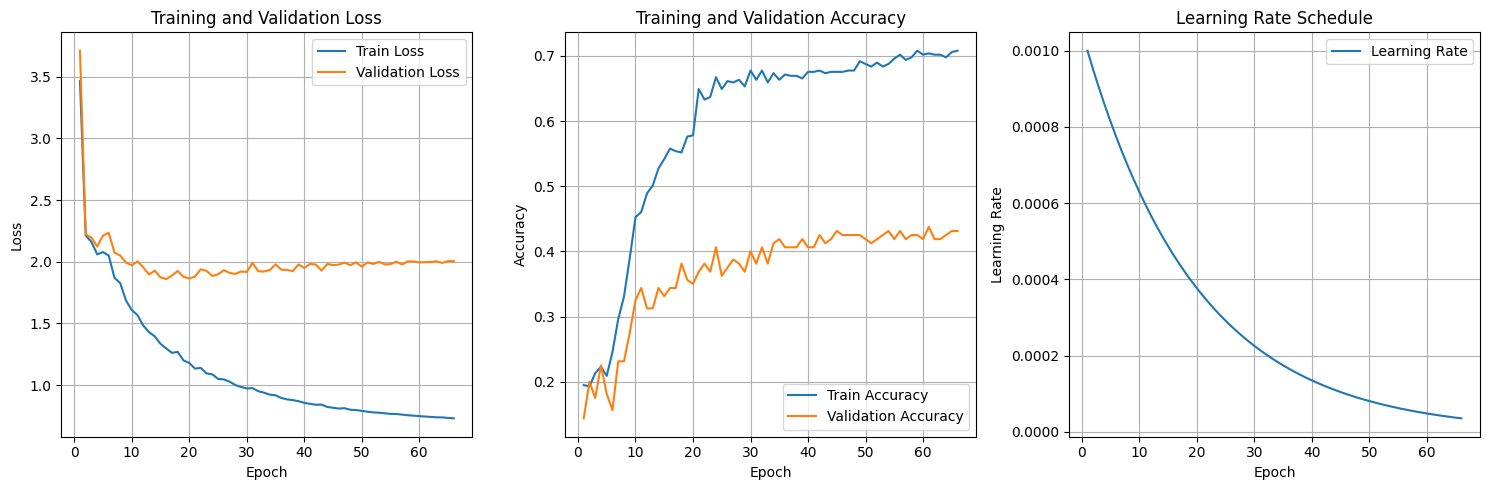

In [15]:
fcnn.trainUltimate(
    epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer='adam',
    l2_lambda=1e-4,
    valX=vFeatures,
    valy=vLabels,
    early_stopping=True,
    patience=10,
    eval_interval=5,
    lr_schedule={'type': 'exponential', 'decay': 0.95}
)

Final Training Accuracy: 0.5578
Final Validation Accuracy: 0.3438


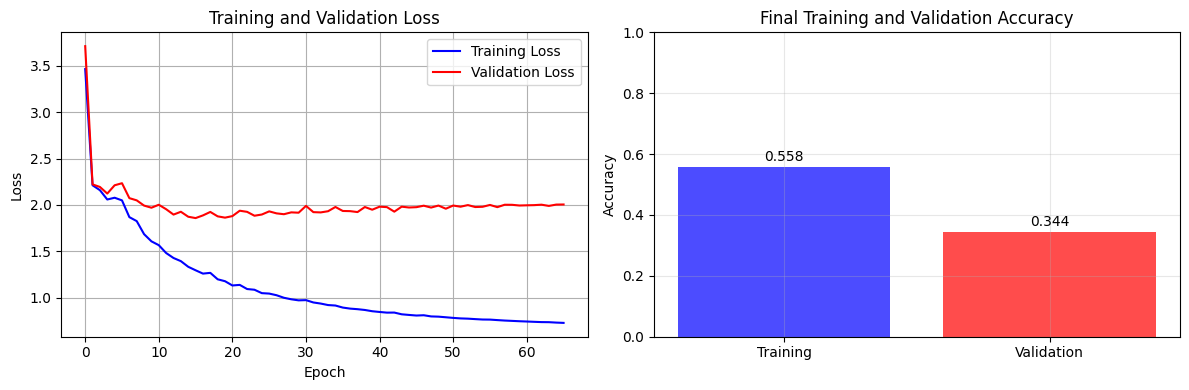

In [16]:
# Plot training results with accuracy
import matplotlib.pyplot as plt

# Extract the loss history from training
train_losses = fcnn.loss_history if hasattr(fcnn, 'loss_history') else []
val_losses = fcnn.val_loss_history if hasattr(fcnn, 'val_loss_history') else []

if train_losses and val_losses:
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Calculate and plot accuracy
    plt.subplot(1, 2, 2)
    
    # Calculate training accuracy
    train_predictions = fcnn.ff(fcnn.X)[1][-1]  # Get final layer output
    train_pred_classes = np.argmax(train_predictions, axis=1)
    train_true_classes = np.argmax(fcnn.y, axis=1)
    train_accuracy = np.mean(train_pred_classes == train_true_classes)
    
    # Calculate validation accuracy
    val_predictions = fcnn.ff(vFeatures)[1][-1]  # Get final layer output
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = np.argmax(vLabels, axis=1)
    val_accuracy = np.mean(val_pred_classes == val_true_classes)
    
    print(f"Final Training Accuracy: {train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")
    
    # For plotting accuracy over time, we'd need to store it during training
    # For now, plot final accuracies as bars
    accuracies = [train_accuracy, val_accuracy]
    labels_acc = ['Training', 'Validation']
    
    plt.bar(labels_acc, accuracies, alpha=0.7, color=['blue', 'red'])
    plt.ylabel('Accuracy')
    plt.title('Final Training and Validation Accuracy')
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("No loss history available. Make sure training completed successfully.")

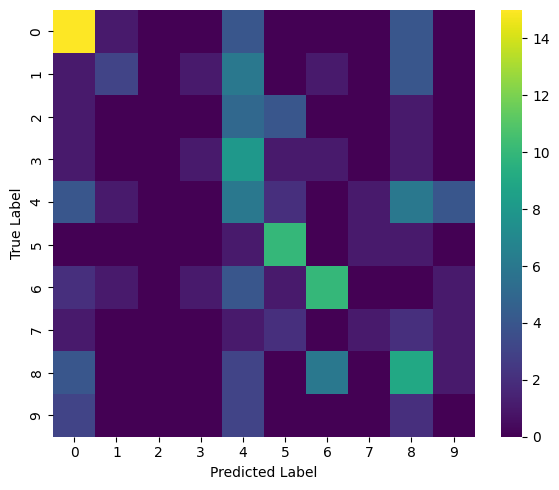

In [17]:
# Display confusion matrix
NnClass.plot_confusion_matrix(vLabels, val_predictions, num_classes=vLabels.shape[1])

In [18]:
# Print detailed results summary
print("="*50)
print("FCNN TRAINING RESULTS SUMMARY")
print("="*50)

print(f"\nDataset Information:")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(trFeatures)}")
print(f"Validation samples: {len(vFeatures)}")
print(f"Features per sample: {trFeatures.shape[1]}")
print(f"Number of classes: {trLabels.shape[1]}")

print(f"\nModel Architecture:")
print(f"Hidden layers: [512, 128, 32]")
print(f"Total parameters: {sum([np.prod(w.shape) for w in fcnn.W[1:] if w is not None])}")

print(f"\nFinal Performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

if hasattr(fcnn, 'loss_history') and fcnn.loss_history:
    final_train_loss = fcnn.loss_history[-1]
    final_val_loss = fcnn.val_loss_history[-1] if fcnn.val_loss_history else "N/A"
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss}")

print("\n" + "="*50)

FCNN TRAINING RESULTS SUMMARY

Dataset Information:
Total samples: 653
Training samples: 493
Validation samples: 160
Features per sample: 70113
Number of classes: 10

Model Architecture:
Hidden layers: [512, 128, 32]
Total parameters: 35967808

Final Performance:
Training Accuracy: 0.5578 (55.78%)
Validation Accuracy: 0.3438 (34.38%)
Final Training Loss: 0.7301
Final Validation Loss: 2.005456986783396

